# Taxi Anomaly Prediction with SparkML

<h3>Data Structure</h3>
<h4>Dimensions</h4>
<ul>
    <li>dropoff_datetime</li>
    <li>dropoff_datetime</li>
    <li>dropoff taxi_zone</li>
    <li>pickup taxi_zone</li>
    <li>vendor</li>
    <li>payment_type</li>
    <li>trip_type</li>
    <li>rate_code_id</li>
    <li>trip_id</li>
    <li>store_and_fwd_flag</li>
    <li>pickup_latitude</li>
    <li>pickup_longitude</li>
    <li>dropoff_latitude</li>
    <li>dropoff_longitude</li>
</ul>

<h4>Measures</h4>
<ul>
    <li>ehail_fee</li>
    <li>extra</li>
    <li>fare_amount</li>
    <li>improvement_surcharge</li>
    <li>mta_tax</li>
    <li>passenger_count</li>
    <li>tip_amount</li>
    <li>tolls_amount</li>
    <li>total_amount</li>
    <li>trip_distance</li>
</ul>


<h4>Dimensions for anomaly detection:</h4>
<ul>
    <li>pickup date</li>
    <li>pickup hour</li>
    <li>pickup taxi zone</li>
    <li>dropoff date</li>
    <li>dropoff hour</li>
    <li>dropoff taxi zone</li>
</ul>

<h4>Measures for anomaly detection:</h4>
<ul>
    <li>total_amount</li>
    <li>trip_distance</li>
    <li>passenger_count</li>
    <li>tip_amount</li>
    <li>trip_count</li>
</ul>

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Path for spark source folder
os.environ['SPARK_HOME'] = "/usr/local/spark-2.3.0"

import findspark
findspark.init()

In [3]:
# Spark imports

from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.clustering import GaussianMixture, GaussianMixtureModel
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import SparseVector
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
# Create spark session

app_name = 'Taxi Anomaly Prediction'

spark = SparkSession \
   .builder \
   .appName(app_name) \
   .enableHiveSupport() \
   .getOrCreate()

In [5]:
# Loading and aggregating raw data
 
# Basically same aggregations Dataflow job does. But if data is trained on raw parquet data,
# it needs to be aggregated like this:
def aggregate(raw_data):
    pickup_datetime = F.unix_timestamp('pickup_datetime')
    dropoff_datetime = F.unix_timestamp('dropoff_datetime')

    pickup_date = F.from_unixtime(pickup_datetime, format='yyyy-MM-dd').alias('pickup_date')
    pickup_hour = F.from_unixtime(pickup_datetime, format='HH').alias('pickup_hour')

    dropoff_date = F.from_unixtime(dropoff_datetime, format='yyyy-MM-dd').alias('dropoff_date')
    dropoff_hour = F.from_unixtime(dropoff_datetime, format='HH').alias('dropoff_hour')

    total_amount = F.sum('total_amount').alias('total_amount')
    trip_distance = F.sum('trip_distance').alias('trip_distance')
    passenger_count = F.sum('passenger_count').alias('passenger_count')
    tip_amount = F.sum('tip_amount').alias('tip_amount')
    trip_count = F.count('trip_id').alias('trip_count')

    agg_data = raw_data.groupBy(pickup_date, pickup_hour, raw_data.pickup_taxizone_id, 
                    dropoff_date, dropoff_hour, raw_data.dropoff_taxizone_id) \
                       .agg(total_amount, trip_distance, passenger_count, 
                            tip_amount, trip_count)
    return agg_data

# For any another data aggregations MUST be re-written.
# Important note: resulting dataframe must have label columns first!

In [6]:
# Path to data the model will be trained on
raw_data_path = "../data/raw-parquet-small/"

# Read raw parquet data
raw_data = spark.read.parquet(raw_data_path)

# Aggregate raw data with function defined above
agg_data = aggregate(raw_data)

agg_data.show()

+-----------+-----------+------------------+------------+------------+-------------------+------------------+------------------+---------------+------------------+----------+
|pickup_date|pickup_hour|pickup_taxizone_id|dropoff_date|dropoff_hour|dropoff_taxizone_id|      total_amount|     trip_distance|passenger_count|        tip_amount|trip_count|
+-----------+-----------+------------------+------------+------------+-------------------+------------------+------------------+---------------+------------------+----------+
| 2009-01-06|         17|               140|  2009-01-06|          18|                129|15.699999809265137| 5.300000190734863|           null|               0.0|         1|
| 2009-01-06|         19|               186|  2009-01-06|          19|                233| 8.300000190734863|1.5099999904632568|           null|               0.0|         1|
| 2009-01-06|         19|               237|  2009-01-06|          19|                239| 8.699999809265137|1.63999998569488

In [7]:
# Convert aggregated data to rdd: it's easier to perform some operations with rdd
aggRDD = agg_data.rdd

# Here we need some 'magic':
# Labels are the columns that contain metadata. Their values are not used while training
# Features are number columns (int, float, whatever) that influence on train and predict
column_count = len(agg_data.columns)

# Labels in dataframe go first, so labels_count defines how many first columns are the labels
labels_count = 6 

# df_to_rdd converts our aggregated dataframe to rdd
# Resulting rdd consists of 2 tuples: labels and features 
# (weird but will be needed later)
# This function is applied to each df row in 'map' function
def df_to_rdd(row):     
    labels = tuple()
    features = tuple()

    for index in range(column_count):
        token = row[index]        
        if(index < labels_count): 
             labels = labels + (token,)
        else:
            # Some fixes if the data is bad
            features = features + ((0.0 if token == None else float(token)),)
    return (labels, features)
    
# Map RDD[Row] to RDD[labels_tuple, features_tuple]
initRDD = aggRDD.map(df_to_rdd)
print(agg_data.columns)

initRDD.take(10)

['pickup_date', 'pickup_hour', 'pickup_taxizone_id', 'dropoff_date', 'dropoff_hour', 'dropoff_taxizone_id', 'total_amount', 'trip_distance', 'passenger_count', 'tip_amount', 'trip_count']


[(('2009-01-06', '17', 140, '2009-01-06', '18', 129),
  (15.699999809265137, 5.300000190734863, 0.0, 0.0, 1.0)),
 (('2009-01-06', '19', 186, '2009-01-06', '19', 233),
  (8.300000190734863, 1.5099999904632568, 0.0, 0.0, 1.0)),
 (('2009-01-06', '19', 237, '2009-01-06', '19', 239),
  (8.699999809265137, 1.6399999856948853, 0.0, 0.0, 1.0)),
 (('2009-01-07', '01', 132, '2009-01-07', '01', 132),
  (3.0, 0.0, 0.0, 0.0, 1.0)),
 (('2009-01-07', '15', 151, '2009-01-07', '16', 263),
  (8.5, 2.0999999046325684, 0.0, 0.0, 1.0)),
 (('2009-01-07', '18', 112, '2009-01-07', '18', 112),
  (10.300000190734863, 1.899999976158142, 0.0, 0.0, 1.0)),
 (('2009-01-08', '14', 158, '2009-01-08', '14', 211),
  (6.900000095367432, 1.5, 0.0, 0.0, 1.0)),
 (('2009-01-08', '15', 196, '2009-01-08', '15', 100),
  (32.880001068115234, 8.470000267028809, 0.0, 6.630000114440918, 1.0)),
 (('2009-01-08', '19', 239, '2009-01-08', '20', 151),
  (5.5, 1.100000023841858, 0.0, 0.0, 1.0)),
 (('2009-01-09', '00', 161, '2009-01-09', 

In [8]:
# Find mins and maxes
# These functions will be needed later for data noramlization

# Intermediate function for rdd's aggregate function
def minMaxSeqOp(agg, data):
    mins = agg[0]
    maxes = agg[1]
    length = len(data[1])
    
    new_mins = [None] * length
    new_maxes = [None] * length
    
    for index, value in enumerate(data[1]):
        new_mins[index] = min(mins[index], value)
        new_maxes[index] = max(maxes[index], value)
    return (new_mins, new_maxes)

# Intermediate function for rdd's aggregate function
def minMaxCombOp(agg1, agg2):
    mins1 = agg1[0]
    maxes1 = agg1[1]
    
    mins2 = agg2[0]
    maxes2 = agg2[1]
    
    length = len(mins1)
    mins = [None] * length
    maxes = [None] * length
    for index, value in enumerate(mins2):
        mins[index] = min(mins1[index], mins2[index])
        maxes[index] = max(maxes1[index], maxes2[index])
    return (mins, maxes)

# Main min/max function that calls previous two
def get_mins_maxes(rdd):
    mins = rdd.first()[1]
    maxes = mins
    return rdd.aggregate((mins, maxes), minMaxSeqOp, minMaxCombOp)

In [9]:
mins, maxes = get_mins_maxes(initRDD)

print("Mins:\t", mins)
print("Maxes:\t", maxes)

Mins:	 [2.5, 0.0, 0.0, 0.0, 1.0]
Maxes:	 [66.9000015258789, 27.399999618530273, 0.0, 11.25, 2.0]


In [10]:
# Normalize data
# Fit all data values from [min, max] to [0, 1]
# TODO: use MinMaxScaler ?

def normalize(data):
    labels = data[0]
    features = data[1]
    
    normalized_features = [None] * len(features)
    for index, value in enumerate(features):
        denominator = (maxes[index] - mins[index]) 
        normalized = (value - mins[index]) / denominator if denominator > 0 else 0.0
        normalized_features[index] = normalized
    return labels, normalized_features

normalizedRDD = initRDD.map(normalize)

print("Normalized data (on the [0, 1] interval) looks like this:")
normalizedRDD.take(10)

Normalized data (on the [0, 1] interval) looks like this:


[(('2009-01-06', '17', 140, '2009-01-06', '18', 129),
  [0.2049689362811702, 0.19343066658842362, 0.0, 0.0, 0.0]),
 (('2009-01-06', '19', 186, '2009-01-06', '19', 233),
  [0.09006211262905257, 0.055109489470286814, 0.0, 0.0, 0.0]),
 (('2009-01-06', '19', 237, '2009-01-06', '19', 239),
  [0.09627328668266708, 0.05985401490975839, 0.0, 0.0, 0.0]),
 (('2009-01-07', '01', 132, '2009-01-07', '01', 132),
  [0.0077639749713216515, 0.0, 0.0, 0.0, 0.0]),
 (('2009-01-07', '15', 151, '2009-01-07', '16', 263),
  [0.09316769965585982, 0.0766423333528941, 0.0, 0.0, 0.0]),
 (('2009-01-07', '18', 112, '2009-01-07', '18', 112),
  [0.12111801251433918, 0.06934306578870154, 0.0, 0.0, 0.0]),
 (('2009-01-08', '14', 158, '2009-01-08', '14', 211),
  [0.06832298122849124, 0.05474452630961239, 0.0, 0.0, 0.0]),
 (('2009-01-08', '15', 196, '2009-01-08', '15', 100),
  [0.4717391358431434, 0.30912410164052173, 0.0, 0.5893333435058594, 0.0]),
 (('2009-01-08', '19', 239, '2009-01-08', '20', 151),
  [0.04658384982792

In [11]:
# These functions are needed to change dataframe format 
# so it will be suitable for model training

# Train dataset has only two columns:
#  - 'labels', which contain, well, labels of the row in array
#  - 'features', which is a tuple of 3: (feature_count, array_of_feature_names, array_of_feature_values)
# I mocked array_of_feature_names so it shows only indices, not real feature names

def to_sparse_vector(values):
    labels = values[0]
    features = values[1]
    
    size = len(features)
    indices = range(0, size)
    return (labels, SparseVector(size, indices, features))

def to_train_df(rdd):
    sparseVectorsRDD = rdd.map(to_sparse_vector)
    trainDataset = sparseVectorsRDD.toDF(["labels", "features"])
    return trainDataset

In [12]:
# Prepare data for training

trainDataset = to_train_df(normalizedRDD)
trainDataset.show(truncate=False)

+------------------------------------------+-------------------------------------------------------------------------------------+
|labels                                    |features                                                                             |
+------------------------------------------+-------------------------------------------------------------------------------------+
|[2009-01-06, 17, 140, 2009-01-06, 18, 129]|(5,[0,1,2,3,4],[0.2049689362811702,0.19343066658842362,0.0,0.0,0.0])                 |
|[2009-01-06, 19, 186, 2009-01-06, 19, 233]|(5,[0,1,2,3,4],[0.09006211262905257,0.055109489470286814,0.0,0.0,0.0])               |
|[2009-01-06, 19, 237, 2009-01-06, 19, 239]|(5,[0,1,2,3,4],[0.09627328668266708,0.05985401490975839,0.0,0.0,0.0])                |
|[2009-01-07, 01, 132, 2009-01-07, 01, 132]|(5,[0,1,2,3,4],[0.0077639749713216515,0.0,0.0,0.0,0.0])                              |
|[2009-01-07, 15, 151, 2009-01-07, 16, 263]|(5,[0,1,2,3,4],[0.09316769965585982,0.0

In [13]:
# PCA method

#First, convert data to 2-dimesional
def to_2_dimensional(rdd):
    featuresRDD = rdd.map(lambda labels_features: labels_features[1])
    matrix = RowMatrix(featuresRDD)
    pca = matrix.computePrincipalComponents(2)
    twoDimensionalRDD = matrix.multiply(pca).rows
    return twoDimensionalRDD

In [14]:
# Principal component analysis
# Shrink our dataset to 2-dimensional to put it on the plot

# if input dataset is too big, take a sample
sampleRDD = normalizedRDD #.sample(False, 0.001)

twoDimensionalRDD = to_2_dimensional(sampleRDD)

print("PCA shrank the data to 2-dimensional: ")
twoDimensionalRDD.take(10)

PCA shrank the data to 2-dimensional: 


[DenseVector([-0.2607, -0.0092]),
 DenseVector([-0.0969, -0.0026]),
 DenseVector([-0.1042, -0.0029]),
 DenseVector([-0.0056, 0.0]),
 DenseVector([-0.1119, -0.0037]),
 DenseVector([-0.1276, -0.0033]),
 DenseVector([-0.0812, -0.0026]),
 DenseVector([-0.7399, -0.0143]),
 DenseVector([-0.057, -0.0019]),
 DenseVector([-0.0998, -0.0033])]

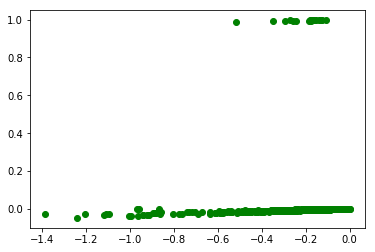

In [15]:
# Put data on the plot to get kernels count

xs = twoDimensionalRDD.map(lambda denseVector: denseVector[0]).collect()
ys = twoDimensionalRDD.map(lambda denseVector: denseVector[1]).collect()

plt.plot(xs, ys, 'go')
plt.show()

In [16]:
# According to data distribution on the plot get the amount of groups (kernels)

KERNELS = 2

In [17]:
# Second method: KMEANS + Silhouette metrics
# Another way to get kernel count
# This is more precise, but take a lot of calculations and time

# First we define how many kernels there could possibly be (from 2 to 7)
MIN_KERNELS = 2
MAX_KERNELS = 7

# Then we use KMeans classification method for each possible kernel count (2, 3, 4...)
for kernel_count in range(MIN_KERNELS, MAX_KERNELS):    
    kmeans = KMeans().setK(kernel_count)
   
    # Train model for kmeans
    model = kmeans.fit(trainDataset)
    
    # Make predictions 
    predictions = model.transform(trainDataset)
    
    # Calculate Silhouette metrics
    # The bigger the Silhouette value, the better kernel count
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Kernel count = " + str(kernel_count) + "; Silhouette with squared euclidean distance = " + str(silhouette))

Kernel count = 2; Silhouette with squared euclidean distance = 0.862074676968966
Kernel count = 3; Silhouette with squared euclidean distance = 0.8961937182015518
Kernel count = 4; Silhouette with squared euclidean distance = 0.9017858526331356
Kernel count = 5; Silhouette with squared euclidean distance = 0.7072762717925812
Kernel count = 6; Silhouette with squared euclidean distance = 0.75251933759418


In [18]:
# The highest value for me was for 4 kernels

KERNELS = 4

In [19]:
# Train Gaussian Mixture Model

gmm = GaussianMixture().setK(KERNELS).setSeed(538009335)
model = gmm.fit(trainDataset)

transformed = model.transform(trainDataset)
transformed.show(truncate=False)

+------------------------------------------+-------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------+
|labels                                    |features                                                                             |prediction|probability                                                                              |
+------------------------------------------+-------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------------------------------+
|[2009-01-06, 17, 140, 2009-01-06, 18, 129]|(5,[0,1,2,3,4],[0.2049689362811702,0.19343066658842362,0.0,0.0,0.0])                 |2         |[2.5190671266513374E-21,1.9528588516340733E-5,0.9999804714114836,2.5190671266513374E-21] |
|[2009-01-06, 19, 186, 2009-01-06, 19, 233]|(5,[0,1,2,3,4],[0.0900621126

In [20]:
def add_anomaly_probability(df):
    # Define custom udf functions
    def maxList(list, index):
        return list.item(index)

    def getAnomalyProbability(probability, kernel_count):
        min_border = 1.0 / kernel_count
        max_border = 1.0
        true_probability = (probability - min_border) / (max_border - min_border)
        return 1 - true_probability
    
    # Register defined udfs
    maxUdf = F.udf(maxList, FloatType())
    getAnomalyProbability = F.udf(getAnomalyProbability, FloatType())
    
    # Call udfs to get max probability and after that - anomaly probability
    df = df.withColumn('max_probability', maxUdf('probability', 'prediction'))
    df = df.withColumn('anomaly_probability', getAnomalyProbability('max_probability', F.lit(KERNELS)))
    
    return df

In [21]:
# Get max probability 

def maxList(list, index):
    return list.item(index)

maxUdf = F.udf(maxList, FloatType())
transformed = transformed.withColumn('max_probability', maxUdf('probability', 'prediction'))
transformed.show()

+--------------------+--------------------+----------+--------------------+---------------+
|              labels|            features|prediction|         probability|max_probability|
+--------------------+--------------------+----------+--------------------+---------------+
|[2009-01-06, 17, ...|(5,[0,1,2,3,4],[0...|         2|[2.51906712665133...|     0.99998045|
|[2009-01-06, 19, ...|(5,[0,1,2,3,4],[0...|         2|[2.16035617137917...|      0.9999986|
|[2009-01-06, 19, ...|(5,[0,1,2,3,4],[0...|         2|[2.31525640163403...|     0.99999857|
|[2009-01-07, 01, ...|(5,[0,1,2,3,4],[0...|         2|[3.72056793211082...|     0.99999815|
|[2009-01-07, 15, ...|(5,[0,1,2,3,4],[0...|         2|[1.34220275639034...|       0.999999|
|[2009-01-07, 18, ...|(5,[0,1,2,3,4],[0...|         2|[8.88485702394556...|     0.99999624|
|[2009-01-08, 14, ...|(5,[0,1,2,3,4],[0...|         2|[1.41451625533109...|     0.99999905|
|[2009-01-08, 15, ...|(5,[0,1,2,3,4],[0...|         1|[3.10911159704659...|     

In [22]:
# Get real probability that data is anomalous

def getAnomalyProbability(probability, kernel_count):
    min_border = 1.0 / kernel_count
    max_border = 1.0
    true_probability = (probability - min_border) / (max_border - min_border)
    return 1 - true_probability

getAnomalyProbability = F.udf(getAnomalyProbability, FloatType())
transformed = transformed.withColumn('anomaly_probability', getAnomalyProbability('max_probability', F.lit(KERNELS)))
transformed.show()

+--------------------+--------------------+----------+--------------------+---------------+-------------------+
|              labels|            features|prediction|         probability|max_probability|anomaly_probability|
+--------------------+--------------------+----------+--------------------+---------------+-------------------+
|[2009-01-06, 17, ...|(5,[0,1,2,3,4],[0...|         2|[2.51906712665133...|     0.99998045|       2.6067099E-5|
|[2009-01-06, 19, ...|(5,[0,1,2,3,4],[0...|         2|[2.16035617137917...|      0.9999986|       1.8278757E-6|
|[2009-01-06, 19, ...|(5,[0,1,2,3,4],[0...|         2|[2.31525640163403...|     0.99999857|       1.9073486E-6|
|[2009-01-07, 01, ...|(5,[0,1,2,3,4],[0...|         2|[3.72056793211082...|     0.99999815|       2.4636586E-6|
|[2009-01-07, 15, ...|(5,[0,1,2,3,4],[0...|         2|[1.34220275639034...|       0.999999|       1.3510386E-6|
|[2009-01-07, 18, ...|(5,[0,1,2,3,4],[0...|         2|[8.88485702394556...|     0.99999624|         5.00

In [23]:
# Saving the model

model_path = 'models/gmm_model'
model.write().overwrite().save(model_path)

In [24]:
# These are some more helpful functions for mapping data
# How it works:
#  - raw data is in parquet
#  - aggregated data is stored in csv

def aggregate_and_save(input_path, output_path, show = False):
    raw_data = spark.read.parquet(input_path)
    agg_data = aggregate(raw_data)
    
    if show:
        print("Aggregated data: ")
        agg_data.show()
    
    agg_data.write.mode("overwrite").csv(output_path, header = True)

def initial_map(line):
    tokens = line.split(',')
    labels = tuple()
    features = tuple()

    for index, token in enumerate(tokens):
        if(index < labels_count): 
             labels = labels + (token,)
        else:
            features = features + ((0.0 if token == '' else float(token)),)
    return (labels, features)


def read_csv_and_map(input_path, labels_count):
    inputRDD = spark.sparkContext.textFile(input_path)
    
    header = inputRDD.first()
    inputRDD = inputRDD.filter(lambda line: line != header)
        
    mappedRDD = inputRDD.map(initial_map) 
    return mappedRDD, header

In [25]:
def prepare_data(input_path, labels_count, agg_path = None):
    csv_path = input_path
    if agg_path != None:
        aggRDD = aggregate_and_save(input_path, agg_path)
        csv_path = agg_path
    
    initRDD, header = read_csv_and_map(csv_path, labels_count)
    normalizedRDD = initRDD.map(normalize)
    preparedDF = to_train_df(normalizedRDD)
    
    return preparedDF, header

In [26]:
# Load model pretrained earlier
loaded_model = GaussianMixtureModel.load(model_path)

In [27]:
# Here goes predict

input_path = '../data/raw-parquet-test/'
agg_path = '../data/aggregated-csv-test/'
# labels_count = 6
testDataset, header = prepare_data(input_path, labels_count, agg_path)


predicted = loaded_model.transform(testDataset)
predicted = add_anomaly_probability(predicted)
predicted.show()

print(header)

+--------------------+--------------------+----------+--------------------+---------------+-------------------+
|              labels|            features|prediction|         probability|max_probability|anomaly_probability|
+--------------------+--------------------+----------+--------------------+---------------+-------------------+
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         1|[0.24999161518396...|     0.25002515|         0.99996644|
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         0|[0.25,0.25,0.25,0...|           0.25|                1.0|
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         0|[0.25,0.25,0.25,0...|           0.25|                1.0|
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         2|[4.96738367050664...|      0.9999971|       3.8941703E-6|
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         1|[7.04454485806572...|            1.0|                0.0|
|[2009-01-05, 18, ...|(5,[0,1,2,3,4],[0...|         1|[1.20842226931444...|            1.0|             

In [28]:
header_tokens = header.split(',')

columns = list()
for index in range(0, labels_count):
    column_name = header_tokens[index]
    df_column_name = "_" + str(index + 1)
    column = predicted.labels[df_column_name].alias(column_name)
    columns.append(column)

columns.append(F.col("anomaly_probability"))

resultDF = predicted.select(columns)

resultDF.show()

+-----------+-----------+------------------+------------+------------+-------------------+-------------------+
|pickup_date|pickup_hour|pickup_taxizone_id|dropoff_date|dropoff_hour|dropoff_taxizone_id|anomaly_probability|
+-----------+-----------+------------------+------------+------------+-------------------+-------------------+
| 2009-01-05|         18|               107|  2009-01-05|          18|                 68|         0.99996644|
| 2009-01-05|         18|               170|  2009-01-05|          18|                137|                1.0|
| 2009-01-05|         18|               234|  2009-01-05|          18|                114|                1.0|
| 2009-01-05|         18|               162|  2009-01-05|          18|                211|       3.8941703E-6|
| 2009-01-05|         18|                42|  2009-01-05|          18|                162|                0.0|
| 2009-01-05|         18|               237|  2009-01-05|          18|                137|                0.0|
|

In [29]:
# Convert Spark dataframe to pandas

resultPD = resultDF.toPandas()
resultPD

pickup_date pickup_hour pickup_taxizone_id dropoff_date dropoff_hour  \
0       2009-01-05          18                107   2009-01-05           18   
1       2009-01-05          18                170   2009-01-05           18   
2       2009-01-05          18                234   2009-01-05           18   
3       2009-01-05          18                162   2009-01-05           18   
4       2009-01-05          18                 42   2009-01-05           18   
5       2009-01-05          18                237   2009-01-05           18   
6       2009-01-05          18                236   2009-01-05           18   
7       2009-01-05          18                144   2009-01-05           18   
8       2009-01-05          18                211   2009-01-05           18   
9       2009-01-05          18                 70   2009-01-05           19   
10      2009-01-05          18                 75   2009-01-05           19   
11      2009-01-05          18                142   2009-01-05           19   
12      2009-01-05          18                246   2009-01-05           19   
13      2009-01-05          18                144   2009-01-05           19   
14      2009-01-05          18                144   2009-01-05           19   
15      2009-01-05          19                162   2009-01-05           19   
16      2009-01-05          19                132   2009-01-05           19   
17      2009-01-05          19                142   2009-01-05           19   
18      2009-01-05          19                236   2009-01-05           19   
19      2009-01-05          19                261   2009-01-05           19   
20      2009-01-05          19                163   2009-01-05           19   
21      2009-01-05          19                132   2009-01-05           19   
22      2009-01-05          19                211   2009-01-05           19   
23      2009-01-05          19                114   2009-01-05           19   
24      2009-01-05          19                164   2009-01-05           19   
25      2009-01-05          19                170   2009-01-05           19   
26      2009-01-05          19                138   2009-01-05           20   
27      2009-01-05          19                231   2009-01-05           20   
28      2009-01-05          19                 43   2009-01-05           20   
29      2009-01-05          19                 25   2009-01-05           19   
...            ...         ...                ...          ...          ...   
360812  2009-01-09          03                224   2009-01-09           03   
360813  2009-01-09          03                148   2009-01-09           03   
360814  2009-01-09          03                137   2009-01-09           03   
360815  2009-01-09          03                186   2009-01-09           03   
360816  2009-01-09          03                161   2009-01-09           03   
360817  2009-01-09          03                238   2009-01-09           03   
360818  2009-01-09          03                238   2009-01-09           03   
360819  2009-01-09          03                229   2009-01-09           03   
360820  2009-01-09          03                249   2009-01-09           03   
360821  2009-01-09          03                 37   2009-01-09           03   
360822  2009-01-09          03                211   2009-01-09           03   
360823  2009-01-09          03                  7   2009-01-09           03   
360824  2009-01-09          03                144   2009-01-09           03   
360825  2009-01-09          03                249   2009-01-09           03   
360826  2009-01-09          03                228   2009-01-09           03   
360827  2009-01-09          03                138   2009-01-09           03   
360828  2009-01-09          03                 79   2009-01-09           04   
360829  2009-01-09          03                148   2009-01-09           04   
360830  2009-01-09          03                 65   2009-

In [30]:
# Map results to records

result_array = resultPD.to_records()

# from collections import namedtuple

# Prediction = namedtuple('Prediction', resultPD.dtypes.index.tolist())
# result_array = list()
# for index, row in enumerate(resultPD):
#     prediction = Prediction(*resultPD.iloc[index,:])
#     result_array.append(prediction)

result_array[:10]

rec.array([(0, '2009-01-05', '18', '107', '2009-01-05', '18', '68', 9.99966443e-01),
           (1, '2009-01-05', '18', '170', '2009-01-05', '18', '137', 1.00000000e+00),
           (2, '2009-01-05', '18', '234', '2009-01-05', '18', '114', 1.00000000e+00),
           (3, '2009-01-05', '18', '162', '2009-01-05', '18', '211', 3.89417028e-06),
           (4, '2009-01-05', '18', '42', '2009-01-05', '18', '162', 0.00000000e+00),
           (5, '2009-01-05', '18', '237', '2009-01-05', '18', '137', 0.00000000e+00),
           (6, '2009-01-05', '18', '236', '2009-01-05', '18', '107', 0.00000000e+00),
           (7, '2009-01-05', '18', '144', '2009-01-05', '18', '148', 0.00000000e+00),
           (8, '2009-01-05', '18', '211', '2009-01-05', '18', '186', 1.08242035e-04),
           (9, '2009-01-05', '18', '70', '2009-01-05', '19', '239', 2.38153771e-01)],
          dtype=[('index', '<i8'), ('pickup_date', 'O'), ('pickup_hour', 'O'), ('pickup_taxizone_id', 'O'), ('dropoff_date', 'O'), ('dropoff_h